In [77]:
import numpy as np
from scipy import fft
from scipy.sparse import csr_matrix
from scipy.io.wavfile import read
from librosa.core import note_to_hz
import matplotlib.pyplot as plt
from scipy.signal import get_window
import scipy
import filters

import torch
import torch.nn as nn
from torch.nn.functional import conv1d
from librosa import stft

# parameters
# nargin = 6
bins = 24 # bins per octave
fs = 22050 # sampling rate

# fmax = 61.73541266 # same as 1 octave
fmax = 880
fmin = note_to_hz('A3')
thresh= 0.0054

stride = 512

s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*450*s, dtype=np.float32) + np.sin(2*np.pi*500*s, dtype=np.float32) +np.sin(2*np.pi*600*s, dtype=np.float32) 

def nextpow2(A):
    return int(np.ceil(np.log2(A)))

def create_cqt_kernals(fmin, fmax, bins, fs, window):
    Q = 1/(2**(1/bins)-1)
    K = np.ceil(bins * np.log2(fmax / fmin)) # Calculate the number of bins
    fftLen = 2**nextpow2(np.ceil(Q * fs / fmin))
    minWin = 2**nextpow2(np.ceil(Q * fs / fmax))
    tempKernel = np.zeros((int(K), int(fftLen)), dtype=np.complex64)
    specKernel = np.zeros((int(K), int(fftLen)), dtype=np.complex64)
    freqs = fmin * 2.0 ** (np.r_[0:K] / np.float(bins))
    for k in range(0, int(K)):
        freq = freqs[k]
        l = np.ceil(Q * fs / freq)
        if l%2==1: # pad more zeros on RHS
            start = int(np.ceil(fftLen / 2.0 - l / 2.0))-1
        else:
            start = int(np.ceil(fftLen / 2.0 - l / 2.0))
        tempKernel[k, start:start + int(l)] = get_window(window,int(l), fftbins=True)*np.exp(np.r_[-l//2:l//2]*1j*2*np.pi*freq/fs)/l
        # specKernel[k, :]=fft(conj(tempKernel[k, :]))
        specKernel[k, :] = fft(tempKernel[k])
        
    return specKernel[:,:fftLen//2+1], fftLen

cqt_filter, kernal_width = create_cqt_kernals(fmin, fmax, bins, fs, 'hann')
cqt_filter_real = torch.tensor(cqt_filter.real)
cqt_filter_imag = torch.tensor(cqt_filter.imag)

wsin, wcos = filters.create_fourier_kernals(kernal_width, windowing="no", freq_scale='no')

In [78]:
x_gpu = torch.tensor(x)
wsin = torch.tensor(wsin)
wcos = torch.tensor(wcos)

In [79]:
fourier_real = conv1d(x_gpu[None,None,:], wcos, stride=stride)
fourier_imag = conv1d(x_gpu[None,None,:], wsin, stride=stride) # Doing STFT by using conv1d

In [4]:
def complex_mul(cqt_filter, stft):
    cqt_filter_real = cqt_filter[0]
    cqt_filter_imag = cqt_filter[1]
    fourier_real = stft[0]
    fourier_imag = stft[1]
    
    CQT_real = torch.matmul(cqt_filter_real, fourier_real) - torch.matmul(cqt_filter_imag, fourier_imag)
    CQT_imag = torch.matmul(cqt_filter_real, fourier_imag) + torch.matmul(cqt_filter_imag, fourier_real)   
    
    return CQT_real, CQT_imag

# GPU implmentation

In [81]:
CQT_real, CQT_imag = complex_mul((cqt_filter_real, cqt_filter_imag), (fourier_real, fourier_imag))

In [82]:
CQT_GPU = torch.sqrt(CQT_real.pow(2)+CQT_imag.pow(2))

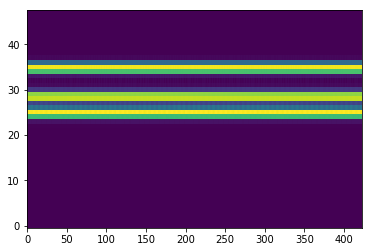

In [83]:
plt.imshow(CQT_GPU[0],aspect='auto', origin='lower')

# CPU implementation

In [84]:
x_fft = stft(x, kernal_width, hop_length=512, window='ones', center=False)

In [85]:
CQT = np.dot(cqt_filter, x_fft)

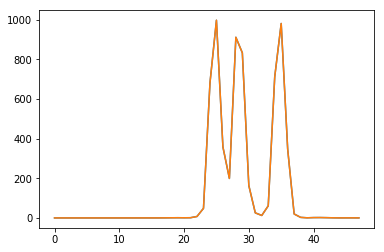

In [86]:
plt.plot(CQT_GPU[0][:,-10].numpy())
plt.plot(abs(CQT)[:,-10])

In [114]:
a = CQT_GPU[0][3].numpy() - abs(CQT)[3]

In [116]:
a.max()

0.00035916595

In [103]:
a.argmax()

236

In [104]:
CQT_GPU[0][3][236].numpy()

array(0.00795012, dtype=float32)

In [105]:
abs(CQT)[3][236]

0.0075909547

Text(0.5, 1.0, 'Python CPU CQT vs Pytorch CQT')

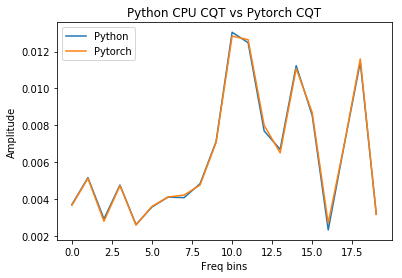

In [119]:

plt.plot(CQT_GPU[0][3].numpy()[210:230])
plt.plot(abs(CQT)[3][210:230])
plt.ylabel('Amplitude')
plt.xlabel('Freq bins')
plt.legend(['Python', 'Pytorch'])
plt.title('Python CPU CQT vs Pytorch CQT')

In [96]:
for i in range(len(abs(CQT))):
    a = np.allclose(CQT_GPU[0][i], abs(CQT)[i],1)
    print(a)

True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


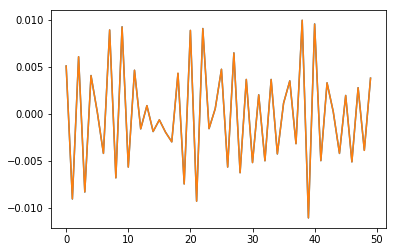

In [129]:
plt.plot(CQT.real[1][50:100])
plt.plot(CQT_real[0][1][50:100].numpy())

In [130]:
CQT.real[1]

array([-4.12438484e-03,  9.15643573e-03, -7.80637516e-03,  8.92673526e-03,
       -6.93750475e-03,  6.48925779e-04,  1.22867804e-03, -6.57858839e-03,
        6.05718791e-03, -8.82385857e-03,  5.35865035e-03, -3.71712074e-03,
        4.37770458e-03, -1.99578027e-03,  4.04783618e-03, -1.55857787e-03,
        3.71691352e-03,  7.70883868e-04, -3.48627032e-03,  5.75053599e-03,
       -1.03680650e-02,  9.40245483e-03, -1.00911660e-02,  3.90171073e-03,
       -2.48220074e-03, -2.11110129e-03,  4.79049515e-03, -4.21379367e-03,
        5.89192053e-03, -2.73114280e-03,  5.54308156e-03, -2.93300510e-03,
        5.10205189e-03, -6.65521575e-03,  5.32304123e-03, -4.05908143e-03,
       -1.27331563e-03,  2.11542705e-03, -9.17240418e-03,  9.27978475e-03,
       -9.19887889e-03,  8.08646902e-03, -4.48088162e-03,  2.72117974e-03,
        3.28097213e-03, -2.78137391e-04,  2.34414195e-03, -2.15420965e-03,
        2.17307778e-03, -4.42036893e-03,  5.10385493e-03, -9.06819478e-03,
        6.09612325e-03, -

In [136]:
manual_CQT = np.dot(cqt_filter.real, x_fft.real) - np.dot(cqt_filter.imag, x_fft.imag)

In [138]:
manual_CQT[0]

array([-4.16480610e-03,  7.99066573e-03, -8.56855139e-03,  8.85130372e-03,
       -6.54618349e-03,  1.34781667e-03,  2.64327298e-03, -5.61876129e-03,
        7.10721314e-03, -7.10272789e-03,  4.60710423e-03, -2.46113958e-03,
        2.26990250e-03, -1.95905985e-03,  2.76490743e-03, -3.35649913e-03,
        3.65868909e-03, -8.78110877e-04, -2.63000024e-03,  5.84704615e-03,
       -9.02229454e-03,  1.03138303e-02, -8.32589343e-03,  4.65675909e-03,
       -1.06648845e-03, -2.55276170e-03,  4.76345746e-03, -4.58148587e-03,
        3.73669388e-03, -2.31121993e-03,  2.66090571e-03, -2.77334126e-03,
        4.19723708e-03, -6.28824905e-03,  6.51201792e-03, -3.70584335e-03,
        9.39185964e-04,  3.08668264e-03, -7.76617555e-03,  9.66534112e-03,
       -8.91343318e-03,  6.78953389e-03, -4.06250916e-03,  4.76318208e-04,
        2.34264228e-03, -1.64721650e-03,  9.76998941e-04, -1.54972682e-03,
        7.41025957e-04, -2.19429145e-03,  5.17178187e-03, -7.55783170e-03,
        7.54925376e-03, -

In [131]:
CQT_real[0][1]

tensor([-4.1931e-03,  9.1536e-03, -7.7766e-03,  8.9175e-03, -6.9555e-03,
         6.5840e-04,  1.2399e-03, -6.5893e-03,  6.0465e-03, -8.8078e-03,
         5.3398e-03, -3.7040e-03,  4.3688e-03, -1.9589e-03,  4.0401e-03,
        -1.5386e-03,  3.7184e-03,  7.6608e-04, -3.4516e-03,  5.7652e-03,
        -1.0361e-02,  9.3910e-03, -1.0076e-02,  3.8922e-03, -2.4738e-03,
        -2.1158e-03,  4.7914e-03, -4.2017e-03,  5.8956e-03, -2.7475e-03,
         5.5363e-03, -2.9497e-03,  5.1006e-03, -6.6486e-03,  5.3202e-03,
        -4.0664e-03, -1.2844e-03,  2.1173e-03, -9.1812e-03,  9.2642e-03,
        -9.2059e-03,  8.0845e-03, -4.4774e-03,  2.6957e-03,  3.2721e-03,
        -2.9573e-04,  2.3765e-03, -2.1589e-03,  2.1727e-03, -4.4343e-03,
         5.1043e-03, -9.0521e-03,  6.0918e-03, -8.3132e-03,  4.0830e-03,
         2.4234e-04, -4.2012e-03,  8.9456e-03, -6.8123e-03,  9.2654e-03,
        -5.6689e-03,  4.6532e-03, -1.5915e-03,  8.8494e-04, -1.8651e-03,
        -6.3102e-04, -1.9591e-03, -2.9763e-03,  4.3